# Guide to Orthomapping (Part 2)

In <a href="Orthomapping_guide_1.ipynb">Part 1</a> we have learnt the concept of Orthomapping, the pre-requisite configuration environment for orthomapping tools to run on, and how to organize imageries and create imagery collection layer item.

Next, Part 2 of this guide will cover how to apply block adjustments, manipulate control points, and compute seamlines and color correction in __Step 2__, and procedures in generating orthomosaic, DEM, and Vegetation Indices through orthomapping tools in __Step 3__. 

Let's get started! First, get connected to your GIS instance.

In [1]:
import arcgis
from arcgis.gis import GIS

portalUrl = "https://yourportal.domain.com/portal"
portalUN = "your username"
portalPW = "your password"

gis = GIS(url=portalUrl, username=portalUN, password=portalPW)

The Image Collection Layer item has already been created in <a href="Orthomapping_guide_1.ipynb">Part 1</a>, so let us reuse the reference to the layer item here.

In [3]:
imagecollectionItem = gis.content.search("omImageCollection")[0]
imagecollectionItem.url

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-2.-Getting-Adjusted" data-toc-modified-id="Step-2.-Getting-Adjusted-1">Step 2. Getting Adjusted</a></span><ul class="toc-item"><li><span><a href="#2.1-Compute-and-apply-initial-block-adjustment" data-toc-modified-id="2.1-Compute-and-apply-initial-block-adjustment-1.1">2.1 Compute and apply initial block adjustment</a></span><ul class="toc-item"><li><span><a href="#2.1.1-Compute-sensor-model" data-toc-modified-id="2.1.1-Compute-sensor-model-1.1.1">2.1.1 Compute sensor model</a></span></li><li><span><a href="#2.1.2-Generate-orthomapping-report-(optional)" data-toc-modified-id="2.1.2-Generate-orthomapping-report-(optional)-1.1.2">2.1.2 Generate orthomapping report (optional)</a></span></li></ul></li><li><span><a href="#2.2-Add-ground-control-points-(optional)" data-toc-modified-id="2.2-Add-ground-control-points-(optional)-1.2">2.2 Add ground control points (optional)</a></span><ul class="toc-item"><li><span><a href="#2.2.1-Compute-control-points" data-toc-modified-id="2.2.1-Compute-control-points-1.2.1">2.2.1 Compute control points</a></span></li><li><span><a href="#2.2.2-Match-control-points" data-toc-modified-id="2.2.2-Match-control-points-1.2.2">2.2.2 Match control points</a></span></li><li><span><a href="#2.2.3-Edit-control-points" data-toc-modified-id="2.2.3-Edit-control-points-1.2.3">2.2.3 Edit control points</a></span></li><li><span><a href="#2.2.4-Query-control-points" data-toc-modified-id="2.2.4-Query-control-points-1.2.4">2.2.4 Query control points</a></span></li><li><span><a href="#2.2.5-Recompute-sensor-model" data-toc-modified-id="2.2.5-Recompute-sensor-model-1.2.5">2.2.5 Recompute sensor model</a></span></li></ul></li><li><span><a href="#2.3-Compute-seamlines" data-toc-modified-id="2.3-Compute-seamlines-1.3">2.3 Compute seamlines</a></span></li><li><span><a href="#2.4-Compute-color-correction" data-toc-modified-id="2.4-Compute-color-correction-1.4">2.4 Compute color correction</a></span></li></ul></li><li><span><a href="#Step-3.-Getting-Results" data-toc-modified-id="Step-3.-Getting-Results-2">Step 3. Getting Results</a></span><ul class="toc-item"><li><span><a href="#3.1-Generate-orthomosaic" data-toc-modified-id="3.1-Generate-orthomosaic-2.1">3.1 Generate orthomosaic</a></span></li><li><span><a href="#3.2-Generate-DEM" data-toc-modified-id="3.2-Generate-DEM-2.2">3.2 Generate DEM</a></span></li><li><span><a href="#3.3-Calculate-vegetation-index-(VARI)---persisting-output-as-hosted-image-service" data-toc-modified-id="3.3-Calculate-vegetation-index-(VARI)---persisting-output-as-hosted-image-service-2.3">3.3 Calculate vegetation index (VARI) - persisting output as hosted image service</a></span></li><li><span><a href="#3.4-Calculate-vegetation-index-(VARI)---through-on-the-fly-processing" data-toc-modified-id="3.4-Calculate-vegetation-index-(VARI)---through-on-the-fly-processing-2.4">3.4 Calculate vegetation index (VARI) - through on-the-fly processing</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-3">References</a></span></li></ul></div>

## Step 2. Getting Adjusted

In Part 1 of this guide, we explained what an ortho image collection is and how to create one for digital aerial imagery. At this point, the imagery has been organized and managed so that we can access all the necessary metadata, information, tools and functionality to work with our imagery, but we haven’t yet performed a bundle block adjustment <a href='#References'>[1]</a>.

### 2.1 Compute and apply initial block adjustment

The `block adjustment` process is defined as "using the ground control and tie point information, a bundle adjustment computation calculates the exterior orientation for each image, such that they are consistent with neighboring images. The orientation for the whole block of images is then adjusted to fit the ground ... produces the best statistical fit between images, for the whole contiguous block, minimizing errors with the ground control" <a href="#References">[2]</a>.

__[arcgis.raster.orthomapping.compute_sensor_model()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#compute-sensor-model)__ computes the bundle block adjustment for the image collection and applies the frame transform to the images, which is based on the raster type information we used when creating the image collection. It also generates the control points feature class, solution table, solution points feature class, and flight path feature class. (These feature classes and tables will be saved in raster store and will not be created in the ArcGIS Enterprise as separated items.)

For preliminary quality purposes, we can perform block adjustment at reduced image resolution using "Quick" mode. This API also supports "Full" and "Refine" modes. Running under these two modes will make it ready for another block adjustment run with more ground control points and matching tie points later on. Once the image collection is in "full" block adjustment states, it will use the existing control point table in the further block adjustments. "mode" parameter will be optional for block adjustment at this time. 

It also offers an adjustment report which can be accessed using __[arcgis.raster.orthomapping.generate_report()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#generate-report)__.

#### 2.1.1 Compute sensor model

In [19]:
from arcgis.raster.orthomapping import compute_sensor_model

In [1]:
compute_sensor_model(image_collection=imagecollectionItem, mode='Quick', location_accuracy='Low')

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'


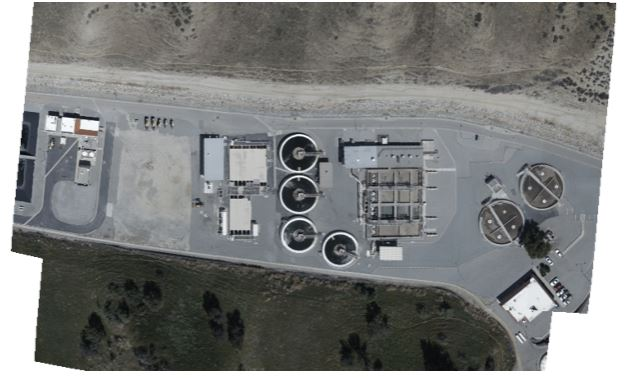

In [1]:
imagecollectionItem.layers[0]

#### 2.1.2 Generate orthomapping report (optional)

The report would contain information about the quality of the adjusted images, the distribution of the control points etc.

In [2]:
from arcgis.raster.orthomapping import generate_report
generate_report(image_collection=imagecollectionItem, report_format="PDF")

'https://yourportal.domain.com/server/rest/directories/arcgisjobs/system/orthomappingtools_gpserver/jfe3fdb2cf00141ab812637b524b6d813/scratch/orthoreport_20190819105129.pdf'

### 2.2 Add ground control points (optional)

In photogrammetry industry, the orthomapping workflow for drone imagery may need to run block adjustment twice. The initial block adjustment is computed to generate the tie points among overlapping images for preliminary results. The second block adjustment is computed with ground control points for refined results.

Note that, it is optional to compute/match/edit/query control points, or recompute sensor model for refined results, as stated in sections 2.2.1 to 2.2.5.

#### 2.2.1 Compute control points

__[arcgis.raster.orthomapping.compute_control_points()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#compute-control-points)__ tool will compute the control point sets between the reference image and the mosaicked image items within the image collection. 

Each control point set will be identified with the same "PointID" in the whole control point feature class. 

Each control point set will consist of one ground control point and matching tie points on all available mosaicked image items of the image collection.

These new control point sets will be added to the control point feature class of the image collection automatically for computing block adjustment later on.

A georeferenced imagery data can be used as reference image layer in order to compute the control points. For example, a previously georeferenced data covering the same area, or __[ArcGIS Online World Imagery](https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer)__. The tool uses advanced image matching algorithm to find ground control points on reference image and its tie points on image collection item. It requires the reference image and the image collection having similar spatial resolution and texture for better image matching results.

In [24]:
from arcgis.raster.orthomapping import compute_control_points

In [4]:
compute_control_points(image_collection=imagecollectionItem, 
                       reference_image="https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer",
                       image_location_accuracy='Low')

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'

#### 2.2.2 Match control points

Alternatively, we can run match control points first, then run edit control points to update the control point feature class.

With given ground control points, __[arcgis.raster.orthomapping.match_control_points()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#match-control-points)__ will help us find all matching tie points on image items of the image collection. 

For each given ground control point, it is required to set at least another matching tie point on image item as input. Then, this tool will help find all remaining tie points on all other image items of the image collection.

The result of this tool will be an array of control point sets. It can be used as input of __[arcgis.raster.orthomapping.edit_control_points()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#edit-control-points)__ tool of orthomapping workflows.

In [26]:
from arcgis.raster.orthomapping import match_control_points

In [27]:
inputControlPoints = [{"pointId": 1,"x": -117.0926538,"y": 34.00704253,"z": 634.2175,
                       "spatialReference": {"wkid":4326},
                       "xyAccuracy": "0.008602325","zAccuracy": "0.015",
                       "imagePoints": [{
                           "imageID": 13,
                           "x": 4932.0895715254455,
                           "y": -1833.8401744114286
                       }] 
                     }]

In [28]:
controlPointSets = match_control_points(image_collection=imagecollectionItem, control_points=inputControlPoints, similarity="High")

In [29]:
controlPointSets

[{'pointID': 1,
  'x': -117.09265379999133,
  'y': 34.007042530296786,
  'z': 634.2174999999988,
  'spatialReference': {'wkid': 4326, 'latestWkid': 4326},
  'xyAccuracy': 0.008602325,
  'ZAccuracy': 0.015,
  'imagePointSpatialReference': {'ics': '', 'topup': True},
  'imagePoints': [{'imageID': 13,
    'x': 4932.087025858724,
    'y': -1833.8399285802177,
    'u': 948.756293148009,
    'v': -545.7443838746151}]}]

#### 2.2.3 Edit control points

Append additional control point sets to the image collection’s control point feature class with __[arcgis.raster.orthomapping.edit_control_points()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#edit-control-points)__ 

In [30]:
from arcgis.raster.orthomapping import edit_control_points

In [31]:
controlPointSets=[{"type":2,"x":-117.0926538,"y":34.00704253,"z":634.2175,
                      "pointId":1,"xyAccuracy":"0.008602325","zAccuracy":"0.015",
                      "imagePoints":[{"imageID":12,"x":5101.184543436052,"y":-2841.9339596208747,"u":545.0939944525426,"v":-468.5878186407665},
                                     {"imageID":2,"x":2020.0648901122495,"y":-2412.6233293180594,"u":3128.136467198136,"v":-2662.994335058943},
                                     {"imageID":13,"x":4932.089326515454,"y":-1833.840551626632,"u":555.357416431812,"v":-1555.0023564815583}]}]

In [5]:
edit_control_points(image_collection=imagecollectionItem, control_points=controlPointSets)

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'

#### 2.2.4 Query control points

An image collections has corresponding control points feature class after computing its sensor model. __[arcgis.raster.orthomapping.query_control_points()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#query-control-points)__ can help query among control point sets which have ground control points inside.

In [33]:
from arcgis.raster.orthomapping import query_control_points

In [ ]:
control_points = query_control_points(image_collection=imagecollectionItem, query="OBJECTID>0")

In [6]:
control_points

[{'pointID': 9461,
  'x': -117.09269999992102,
  'y': 34.006999999284744,
  'z': 634.2174999999988,
  'spatialReference': {'wkid': 32611, 'latestWkid': 32611},
  'xyAccuracy': 0.008602325,
  'ZAccuracy': 0.015,
  'imagePointSpatialReference': {'wkid': 32611, 'latestWkid': 32611},
  'imagePoints': [{'imageID': 12,
    'x': 491448.85840000026,
    'y': 3762905.8003000002,
    'u': 545.093994453,
    'v': -468.587818641},
   {'imageID': 2,
    'x': 491425.1074999999,
    'y': 3762931.9886000007,
    'u': 3128.1364672,
    'v': -2662.99433506},
   {'imageID': 13,
    'x': 491447.1553999996,
    'y': 3762935.4902999997,
    'u': 555.357416432,
    'v': -1555.00235648}]}]

#### 2.2.5 Recompute sensor model

After adding the ground control point sets to the image collection's control point table with steps above, we can rerun compute sensor model to refine block adjustment result.

In [7]:
compute_sensor_model(image_collection=imagecollectionItem, mode='Refine', location_accuracy='Medium')

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'

### 2.3 Compute seamlines

__[arcgis.raster.orthomapping.compute_seamlines()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#compute-seamlines)__ task is used to compute seamlines for overlaid images inside the image collection, usually after the image collection has been block adjusted. Seamlines are helpful for generating the seamless mosaicked display for overlapped images in image collection. 

In [23]:
from arcgis.raster.orthomapping import compute_seamlines

In [9]:
compute_seamlines(image_collection=imagecollectionItem, seamlines_method="DISPARITY",
                  context={"minRegionSize":100, "blendType":"Both", "blendWidth":None, "blendUnit":"Pixels", 
                           "requestSizeType":"Pixels", "requestSize":1000, "minThinnessRatio":0.07, "maxSilverSize":20})

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'


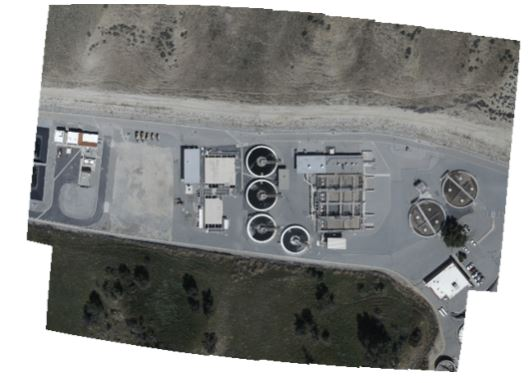

In [2]:
imagecollectionItem.layers[0]

### 2.4 Compute color correction 

After image collection’s sensor model is computed, __[arcgis.raster.orthomapping.color_correction()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#color-correction)__ can be called to improve the visual appearance.

This is often needed for satellite data as the cross-strip images are often collected on different days with different atmospheric conditions.

In [26]:
from arcgis.raster.orthomapping import color_correction

In [10]:
color_correction(image_collection=imagecollectionItem, color_correction_method="DODGING", dodging_surface_type="SECOND_ORDER",
                 context={"skipRows": 10, "skipCols": 10, "reCalculateStats": "OVERWRITE"})

'https://yourportal.domain.com/server/rest/services/Hosted/omImageCollection/ImageServer'


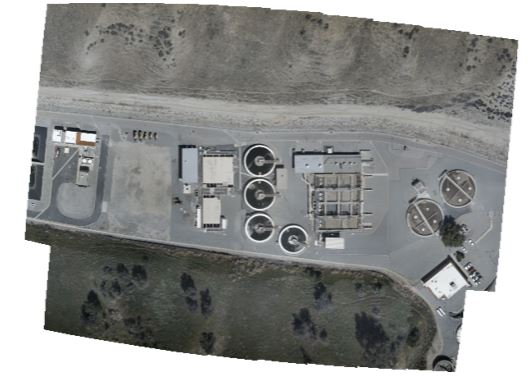

In [3]:
imagecollectionItem.layers[0]

The block adjustment tools allow for an iterative computation, so that you can check on the quality of the adjustment, modify options, add or delete GCPs, or recompute tie points before re-running the adjustment. If you are unsatisfied with the error in the Adjustment Report, try adding GCPs, or try modifying some of the Adjustment Options. You can also change some of your check points back into GCPs, and choose a few other GCPs to be your check points. Re-run the adjustment and see how this impacts the shift. Once you are satisfied with the accuracy of your adjusted imagery, it’s time to make ortho products <a href='#References'>[1]</a>!


## Step 3. Getting Results

### 3.1 Generate orthomosaic

After the block adjustment, ortho-rectified imagery layer can be created from the image collection with __[arcgis.raster.orthomapping.generate_orthomosaic()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#generate-orthomosaic)__

This function comes with the option to choose whether or not using existing seamlines of the image collection for the orthomosaic imagery layer. Also, it has an option to choose whether or not to apply color correction settings to the output orthomosaic imagery layer. These can be set through the regen_seamlines and recompute_color_correction parameters. 

In [29]:
from arcgis.raster.orthomapping import generate_orthomosaic

In [30]:
orthomosaicName = "omOrthoMosaic"
orthomosaicItem = generate_orthomosaic(image_collection=imagecollectionItem, out_ortho=orthomosaicName,
                                       regen_seamlines=True, recompute_color_correction=True, folder=prjFolderName)

In [11]:
orthomosaicItem.url

'https://yourportal.domain.com/server/rest/services/Hosted/omOrthoMosaic/ImageServer'


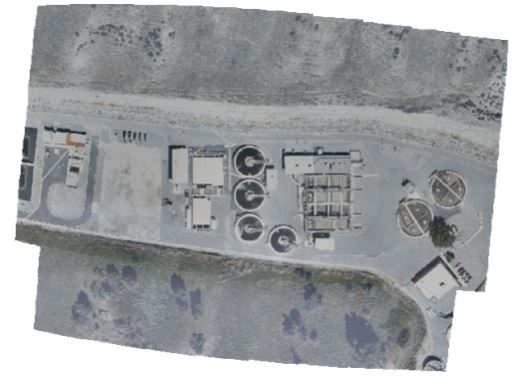

In [4]:
orthomosaicItem.layers[0]

### 3.2 Generate DEM

DEM products can be generated from image collections which have been block adjusted with __[arcgis.raster.orthomapping.generate_dem()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.orthomapping.html#generate-dem)__. It creates dense point cloud using adjusted image collections, then interpolates the point cloud to generate different DEM surface types using the designated method. 

Two types of DEMs that can be produced are DTM and DSM <a href='#References'>[1]</a>:

__DTM__ — Digital elevation of the earth, not including the elevation of any objects on it, can used to produce the orthoimage and orthomosaics.

__DSM__ — Digital elevation of the earth, including the elevation of objects on it such as trees and buildings, can be used for classifying features in orthoimages, such as discriminating asphalt pavement and asphalt roofs. It should not be used for image orthorectification unless the source imagery is nadir looking, with no building or feature lean, to produce true orthoimages.

In [32]:
from arcgis.raster.orthomapping import generate_dem

In [34]:
dsmName = "omDigitalSurfaceModel"
dsmItem=generate_dem(image_collection=imagecollectionItem, out_dem=dsmName, cell_size=0.1314245599999937,
                     surface_type="DSM", matching_method="ETM",
                     context={"maxObjectSize":15,"minAngle":10,"maxAngle":70,"minOverlap":0.6,"maxGSDDif":2,
                              "numImagePairs":8,"adjQualityThreshold":0.2,"method":"TRIANGULATION",
                              "smoothingMethod":"GAUSS5x5","applyToOrtho":True,"regenPointCloud":False},
                     folder=prjFolderName)

In [12]:
dsmItem.url

'https://yourportal.domain.com/server/rest/services/Hosted/omDigitalSurfaceModel/ImageServer'


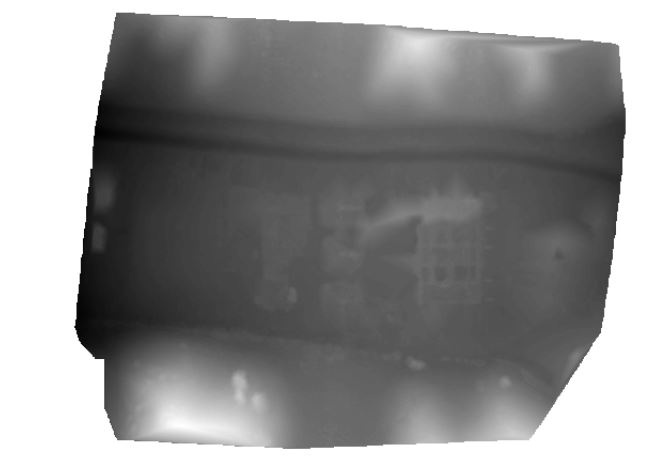

In [13]:
dsmItem.layers[0]

### 3.3 Calculate vegetation index (VARI) - persisting output as hosted image service

__[arcgis.raster.analytics.generate_raster()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.analytics.html#generate-raster)__ is used to generate rasters based on any raster function templates you build. The result will be stored inside server's raster store and serving out as hosted image services directly.

In [39]:
from arcgis.raster.analytics import generate_raster

In [40]:
variRasterFunctionTemplate = {
    "rasterFunction" : "BandArithmetic",
    "rasterFunctionArguments" : {
        "Method" : 9, # 9 indicates the build-in Visible Atmospherically Resistant Index calculation 
        "BandIndexes" : "3 2 1", # Band number for Red, Green, Blue data used in VARI calculation.
        "Raster" : {
            "url" : orthomosaicItem.url
        }
    }
}

In [41]:
variName = "omVARI"
variItem = generate_raster(raster_function=variRasterFunctionTemplate, 
                           output_name=variName)


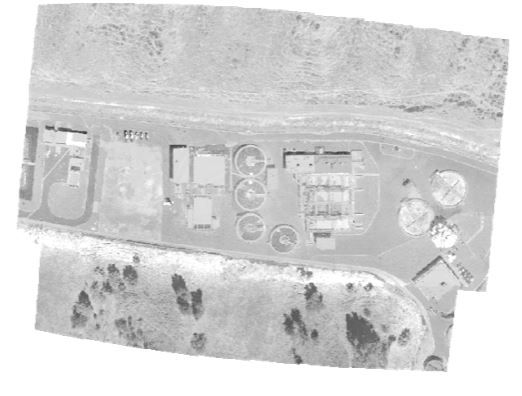

In [5]:
variItem.layers[0]

### 3.4 Calculate vegetation index (VARI) - through on-the-fly processing

In contrast with method above, __[arcgis.raster.functions](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.raster.functions.html)__ module also contains many build-in raster functions that can be applied on imagery layer items on the fly for dynamic analysis.

In [43]:
from arcgis.raster.functions import band_arithmetic


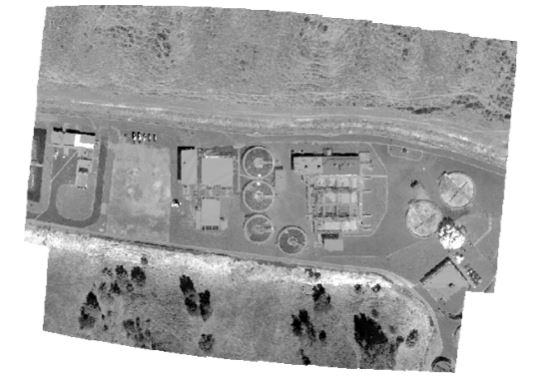

In [6]:
band_arithmetic(raster=orthomosaicItem.layers[0], 
                band_indexes="3 2 1",
                method=9)

In Part 2, we have gone through processes to create a DTM or DSM, and an orthomosaic with aerial digital imagery, etc. using Python API methods. With these results, you can go on to do all kinds of analysis with elevation data, or use your orthomosaic map for applications in emergency response, resource management, real estate, and more <a href='#References'>[3]</a>.

Last but not least, we will talk about how to handle the processed imageries in <a href='Orthomapping_guide_3.ipynb'>Part 3</a>, which includes how to add/delete images in the image collection, and reset/delete the image collection. Please stay tuned!

## References

<a href="#Step-2.-Getting-Adjusted">[1]</a> Lenhardt, Ortho Mapping in ArcGIS Pro Part II: Getting Adjusted, https://www.esri.com/arcgis-blog/products/arcgis-pro/imagery/ortho-mapping-arcgis-block-adjustment/ [Online] [Assessed on August 13, 2019]

<a href="#Step-2.-Getting-Adjusted">[2]</a> Lenhardt & Liedtke, Ortho Mapping in ArcGIS Pro Part I: Getting Organized with a Workspace, https://www.esri.com/arcgis-blog/products/arcgis-pro/imagery/ortho-mapping-workspace/ [Online] [Assessed on August 13, 2019]

<a href="#References">[3]</a> Lenhardt, Ortho Mapping in ArcGIS Pro Part III: Getting Results,https://www.esri.com/arcgis-blog/products/arcgis-pro/imagery/ortho-mapping-products-arcgis-pro/ [Online] [Assessed on August 13, 2019]